In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os

plt.rcParams['svg.fonttype'] = 'none'


In [2]:
def oscillation_power_intervals(chan, intervals, nbins, fmin, fmax, fs=1250):
    intervals_power_matrix = []
    for s, e in intervals.as_units('s').iloc():
        if e-s<50: continue
        inter = nts.IntervalSet(s, e, time_units='s')
        lfp = bk.load.lfp_in_intervals(chan, inter)
        f, t, Sxx = scipy.signal.spectrogram(lfp.values, fs,nperseg = 2500,noverlap=500)
        
        ## VERY UGLY DO NOT DO THIS ##
        # time_bins = np.histogram_bin_edges(t, nbins)
        #     for i, b in enumerate(time_bins[:-1]):
        #     time_filter = (b <= t) & (t <= time_bins[i+1])
        #     band_power.append(np.nanmean(Sxx[band_filter][:,time_filter]))

        Sxx,t = scipy.signal.resample(Sxx,nbins,t,axis = 1)
        band_filter = (fmin < f) * (f < fmax)
        intervals_power_matrix.append(np.nanmean(Sxx[band_filter,:],0))
        bin_size = inter.duration(time_units='s')/nbins

    return np.array(intervals_power_matrix)


In [3]:
def main(base_folder, local_path, *args, **kwargs):
    bk.load.current_session_linux(base_folder, local_path)
    states = bk.load.states()
    for s in ['wake', 'drowsy']:
        states.pop(s)

    channels = {'bla_left': bk.load.bla_channels()['left'],
                'bla_right': bk.load.bla_channels()['right'],
                'hpc': bk.load.ripple_channel()}

    all_oscillations_power = {}
    for k, state in states.items():
        all_oscillations_power.update({k: {}})
        for kk, chan in channels.items():
            if np.isnan(chan):
                continue
            oscillations_power = oscillation_power_intervals(chan,
                                                             state,
                                                             kwargs['nbins'],
                                                             kwargs['fmin'],
                                                             kwargs['fmax'])

            all_oscillations_power[k].update({kk: oscillations_power})

    return all_oscillations_power


def merge(batch):
    power = {}
    for session, b in batch.items():
        for state, s in b.items():
            if state not in power.keys():
                power.update({state: {}})
            for stru, p in s.items():
                if stru not in power[state].keys():
                    power[state].update({stru: []})
                power[state][stru].append(p)

    for state in power:
        for stru in power[state]:
            power[state][stru] = np.vstack(power[state][stru])

    return power


def plot(merged, ymin=None, ymax=None):
    fig, ax = plt.subplots(1, 3)
    for i, (state, o) in enumerate(merged.items()):
        for stru, power in o.items():
            # power = zscore(power,1)
            t = len(np.nanmean(power, 0))
            std = scipy.stats.sem(power, 0)*1.96
            # std = np.std(power,0)
            # std = 1.960 * std/np.mean(power,0)
            m = np.nanmean(power, 0)
            ax[i].plot(m)
            ax[i].fill_between(range(t), m-std, m+std, alpha=0.2)
        ax[i].set_ylim(ymin, ymax)
        ax[i].set_title(state)
        ax[i].legend(o.keys())
        plt.tight_layout()


In [144]:
kwargs = {'fmin':4,
          'fmax':12,
          'nbins':30}
output = main('/mnt/electrophy/Gabrielle/GG-Dataset','Rat08/Rat08-20130713',**kwargs)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset/Rat08/Rat08-20130713


In [4]:
kwargs = {'fmin':6,
          'fmax':10,
          'nbins':30}
batch_theta = bk.load.batch(main,local_base='/mnt/electrophy/Gabrielle/GG-Dataset',**kwargs)

kwargs = {'fmin':.5,
          'fmax':4,
          'nbins':30}
batch_delta = bk.load.batch(main,local_base='/mnt/electrophy/Gabrielle/GG-Dataset',**kwargs)

kwargs = {'fmin':30,
          'fmax':80,
          'nbins':30}
batch_gamma = bk.load.batch(main,local_base='/mnt/electrophy/Gabrielle/GG-Dataset',**kwargs)

100%|██████████| 61/61 [3:14:32<00:00, 191.34s/it]

Batch finished in 11672.034720897675
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140327', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
36.0655737704918 %


In [5]:
os.chdir('/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/Oscillations_Across_States/')

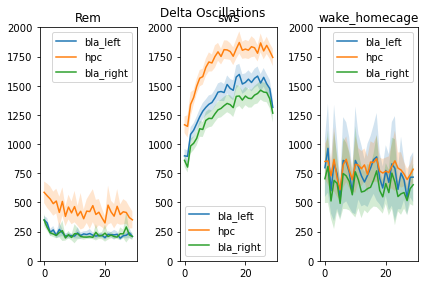

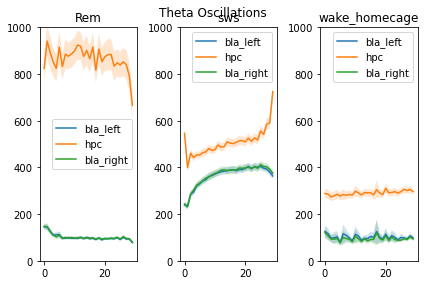

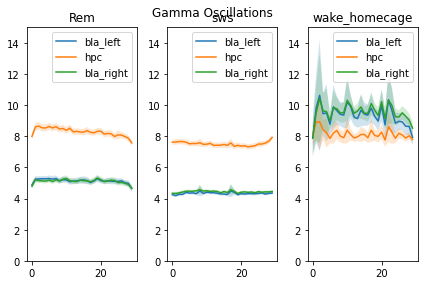

In [8]:
merged_delta = merge(batch_delta)
plot(merged_delta,0,2000)
plt.suptitle('Delta Oscillations')
plt.savefig('delta.svg')

merged_theta = merge(batch_theta)
plot(merged_theta,0,1000)
plt.suptitle('Theta Oscillations')
plt.savefig('theta.svg')

merged_gamma = merge(batch_gamma)
plot(merged_gamma,0,15)
plt.suptitle('Gamma Oscillations')
plt.savefig('gamma.svg')


In [ ]:

fig,ax = plt.subplots(1,2)
for i,(state,o) in enumerate(delta_power.items()):
    for stru,power in o.items():


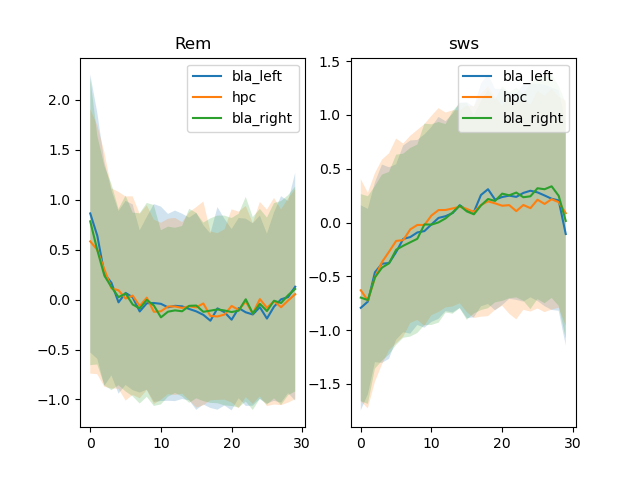

In [23]:
delta_power = {}
for session,b in batch_delta.items():
    for state,s in b.items():
        if state not in delta_power.keys(): delta_power.update({state:{}})
        for stru,power in s.items():
            if stru not in delta_power[state].keys(): delta_power[state].update({stru:[]})
            delta_power[state][stru].append(power)

%matplotlib widget
fig,ax = plt.subplots(1,2)
for i,(state,o) in enumerate(delta_power.items()):
    for stru,power in o.items():
        power = np.vstack(power)
        power = zscore(power,1)
        t = len(np.nanmean(power,0))
        std = np.nanstd(power,0)
        m = np.nanmean(power,0)
        ax[i].plot(m)
        ax[i].fill_between(range(t),m-std,m+std,alpha = 0.2)
    ax[i].set_title(state)
    ax[i].legend(o.keys())

In [ ]:
%matplotlib widget
fig,ax = plt.subplots(1,2)
for i,(state,o) in enumerate(delta_power.items()):
    for stru,power in o.items():
        power = np.vstack(power)
        # power = zscore(power,1)
        t = len(np.nanmean(power,0))
        std = np.nanstd(power,0)
        m = np.nanmean(power,0)
        ax[i].plot(m)
        ax[i].fill_between(range(t),m-std,m+std,alpha = 0.2)
    ax[i].set_title(state)
    ax[i].legend(o.keys())

In [52]:
def flatten(t):
    return [item for sublist in t for item in sublist]

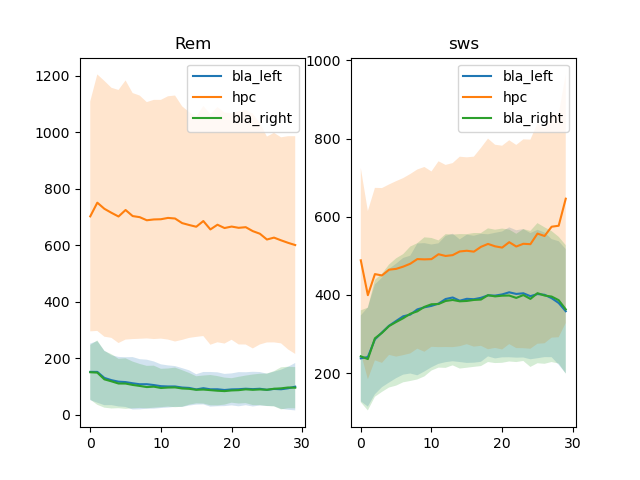

In [17]:
%matplotlib widget
fig,ax = plt.subplots(1,2)
for i,(state,o) in enumerate(delta_power.items()):
    for stru,power in o.items():
        power = np.vstack(power)
        # power = zscore(power,1)
        t = len(np.nanmean(power,0))
        std = np.nanstd(power,0)
        m = np.nanmean(power,0)
        ax[i].plot(m)
        ax[i].fill_between(range(t),m-std,m+std,alpha = 0.2)
    ax[i].set_title(state)
    ax[i].legend(o.keys())

In [2]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os

plt.rcParams['svg.fonttype'] = 'none'


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


/tmp/ipykernel_1612903/2321637417.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolor(t,f,Sxx,vmin = 0,vmax = 5000)
/tmp/ipykernel_1612903/2321637417.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolor(t_re,f,Sxx_re,vmin = 0,vmax = 5000)


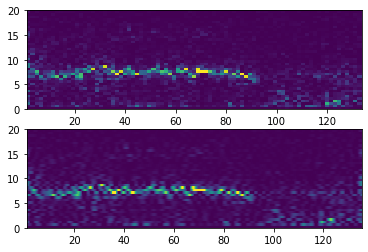

In [32]:
bk.load.current_session_linux()
states = bk.load.states()
chan = bk.load.ripple_channel()
for s,e in states['Rem'].as_units('s').iloc:
    lfp = bk.load.lfp(chan,int(s),int(e)+50)
    f,t,Sxx = scipy.signal.spectrogram(lfp.values,1250,nperseg=2500,noverlap=500)
    Sxx_re,t_re = scipy.signal.resample(Sxx,5000,t,axis = 1)
    
    fig, ax = plt.subplots(2,1)
    ax[0].pcolor(t,f,Sxx,vmin = 0,vmax = 5000)
    ax[1].pcolor(t_re,f,Sxx_re,vmin = 0,vmax = 5000)

    for a in ax:
        a.set_ylim(0,20)
    break

In [34]:
Sxx.shape

(1251, 84)

In [35]:
np.nanmean(Sxx,0).shape

(84,)